Lambda School Data Science

*Unit 4, Sprint 1, Module 3*

---

# Document Classification (Assignment)

This notebook is for you to practice skills during lecture.

Today's guided module project and assignment will be different. You already know how to do classification. You ready know how to extract features from documents. So? That means you're ready to combine and practice those skills in a kaggle competition. We we will open with a five minute sprint explaining the competition, and then give you 25 minutes to work. After those twenty five minutes are up, I will give a 5-minute demo an NLP technique that will help you with document classification (*and **maybe** the competition*).

Today's all about having fun and practicing your skills.

## Sections
* <a href="#p1">Part 1</a>: Text Feature Extraction & Classification Pipelines
* <a href="#p2">Part 2</a>: Latent Semantic Indexing
* <a href="#p3">Part 3</a>: Word Embeddings with Spacy
* <a href="#p4">Part 4</a>: Post Lecture Assignment

# Text Feature Extraction & Classification Pipelines (Learn)
<a id="p1"></a>

## Follow Along 

What you should be doing now:
1. Join the Kaggle Competition
2. Download the data
3. Train a model (try using the pipe method I just demoed)

### Load Competition Data

In [1]:
# Importing necessary modules.

import pandas as pd
import scipy.stats as stats
import seaborn as sns
sns.set()
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from explore_data import *

In [67]:
# Importing the kaggle data.

train = pd.read_csv('./whiskey-reviews-dspt4/train.csv')
test = pd.read_csv('./whiskey-reviews-dspt4/test.csv')
print(train.shape, test.shape)

(4087, 3) (1022, 2)


### Exploring the Data

In [3]:
# First peek at the data.

train.head()

,id,description,ratingCategory
0,1321,"\nSometimes, when whisky is batched, a few lef...",1
1,3861,\nAn uncommon exclusive bottling of a 6 year o...,0
2,655,\nThis release is a port version of Amrut’s In...,1
3,555,\nThis 41 year old single cask was aged in a s...,1
4,1965,"\nQuite herbal on the nose, with aromas of dri...",1


In [4]:
# Get the median number of words per sample.

median_words_per_sample = get_num_words_per_sample(train['description'])
print(f'Median words per sample: {median_words_per_sample}')

Median words per sample: 70.0


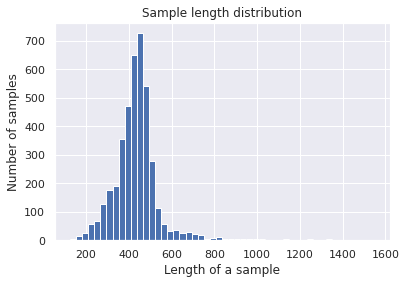

In [5]:
# Distribution of the review lengths - appears to be normal.

plot_sample_length_distribution(train['description'])

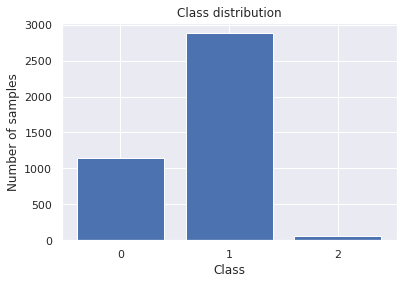

In [6]:
# Distribution of ratingCategory: 0 (Excellent), 1 (Good), 2 (Poor)
# There is very few poor category reviews.

plot_class_distribution(train['ratingCategory'])

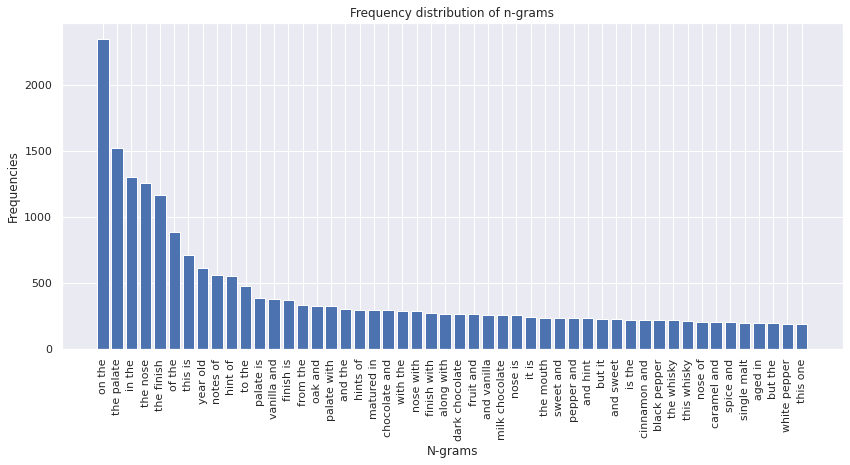

In [30]:
# Get a plot of 50 most used terms.
# Vanilla, fruit, chocolate, spice, orange, caramel, pepper and honey show what drinkers
# might look for in terms of flavor.

plot_frequency_distribution_of_ngrams(train['description'],
                                      ngram_range=(2, 2),
                                      num_ngrams=50)

In [8]:
# Read a few reviews from the "Excellent" category
pd.set_option('display.max_colwidth', 0)
train[train.ratingCategory == 0].sample(3)

,id,description,ratingCategory
2210,4126,"\nOriginally exclusive to the Swedish market, this expression was selected by Highland Park’s Danish brand ambassador Martin Markvardsen. Matured in a combination of 70% bourbon barrels and 30% oloroso sherry casks. Waxy and malty on the early nose, with fresh earth, damp moss, vanilla, and honey. Gentle peat on the palate, more earthy notes; herbal, with lime and salt. The finish is quite short, showing apricots, slight peatiness, allspice.",0
3305,4220,"\nDistilled from a mash of malted two-row Canadian barley, and matured indoors for exactly 1,221 days in a first-fill bourbon barrel, Cask 8 is glowingly warm with soaring notes of acetone and sweet esters on a base redolent of linseed oil, gunnysacks, and grassy cereals. The palate is sweetish, like gummy bears, and very spicy. Pepper, ginger, and hot cinnamon bathe in a weighty, creamy body. A longish finish shows soft, oaky barrel notes. (Distillery only) C$70",0
3552,3847,"\nIt shows nice maturity, considering it contains whiskey as young as two years old. Smooth, too, with layered sweetness (honeyed caramel, English toffee, maple syrup), tangerine, roasted nuts, and peppered with spice (warming cinnamon, glazed ginger). Good grip of tobacco and polished leather on the finish balances the sweetness that comes earlier. An example of the right way to do artisan distilling.",0


In [9]:
# Read a few reviews from the "Poor" category
train[train.ratingCategory == 2].sample(3)

,id,description,ratingCategory
1259,5034,"\nIt's great that Irish whiskey is thriving and William Grant has bought Tullamore Dew. But they need help. To paraphrase English football fans, someone doesn't know what he's doing. The label says this is 12 years old, small batch, and limited edition. What? The normal whiskey is a blend and there's no distillery. So what is this, and why small batch? The whiskey's a mess, too — flabby, characterless, and confused — the whiskey equivalent of a karaoke singer doing Led Zeppelin.",2
2259,5055,"\nGiven the Beam house character of cinnamon, I thought this was redundant till I got a whiff of the sweet cinnamon coming off this, like a tea made from Red Hots candies. The drink itself is thickly sweet, and more of the hot cinnamon candy overwhelms anything else; the bourbon is largely lost here. If anything, the finish is even more heavy-handed.",2
1614,5050,"\nHuge oak impact for such a young whisky. Fresh oak shavings, dry vanilla, and subtle toasted coconut throughout. Some dried fruit, sultana, and toffee up front, but this is quickly consumed by the oak. Dry, hot, resinous finish. Not an old whisky, but already showing too much oak.\r\n",2


In [10]:
# Getting the S/W ratio to see what path should we take on the Google flowchart.

sw_ratio = len(train['description']) / median_words_per_sample
print(f'Number of Samples / Median Words per Sample ratio: {int(sw_ratio)}')

Number of Samples / Median Words per Sample ratio: 58


### Split the Training Set into Train/Validation

In [11]:
# Split our train data into train, test portions.

X_train, X_test, y_train, y_test = train_test_split(train['description'],
                                                    train['ratingCategory'],
                                                    test_size=0.2,
                                                    stratify=train['ratingCategory'],
                                                    random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3269,) (818,) (3269,) (818,)


### Define Pipeline Components

In [31]:
# Create Pipeline Components

vect = TfidfVectorizer(stop_words='english', ngram_range=(2, 2))
rfc = RandomForestClassifier()

In [32]:
# Get sparse dtm

dtm = vect.fit_transform(X_train)

# Convert to dataframe

dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm.shape

(3269, 91347)

In [33]:
# Define the Pipeline

pipe = Pipeline([
    ('vect', vect),      # TF-IDF Vectorizer
    ('clf', rfc)         # RandomForest Classifier
])

### Define Your Search Space
You're looking for both the best hyperparameters of your vectorizer and your classification model. 

In [34]:
parameters = {
    'vect__max_df': (0.5, 0.7, 1.0),
    'vect__min_df': (2, 5, 10),
    'vect__max_features': (5000, 10000, 20000),
    'clf__n_estimators': (100, 250, 500),
    'clf__max_depth': (10, 20, None),   
}

grid_search = GridSearchCV(pipe, parameters, cv=3, n_jobs=-3, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  30 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-3)]: Done 180 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-3)]: Done 430 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-3)]: Done 729 out of 729 | elapsed:  2.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(2, 2),
                                                        no

In [35]:
grid_search.best_score_

0.7133691656627437

In [36]:
grid_search.best_params_

{'clf__max_depth': None,
 'clf__n_estimators': 250,
 'vect__max_df': 1.0,
 'vect__max_features': 10000,
 'vect__min_df': 2}

In [37]:
# Evaluate on test data

y_actual = grid_search.predict(X_test)
accuracy_score(y_test, y_actual)

0.6980440097799511

### Make a Submission File
*Note:* In a typical Kaggle competition, you are only allowed two submissions a day, so you only submit if you feel you cannot achieve higher test accuracy. For this competition the max daily submissions are capped at **20**. Submit for each demo and for your assignment. 

In [23]:
# Predictions on test sample
pred = grid_search.predict(test['description'])

In [24]:
submission = pd.DataFrame({'id': test['id'], 'ratingCategory':pred})
submission['ratingCategory'] = submission['ratingCategory'].astype('int64')

In [25]:
# Make Sure the Category is an Integer
submission.head()

,id,ratingCategory
0,3461,1
1,2604,1
2,3341,1
3,3764,1
4,2306,1


In [26]:
subNumber = 0

In [27]:
# Save your Submission File
# Best to Use an Integer or Timestamp for different versions of your model

submission.to_csv(f'./whiskey-reviews-dspt4/submission{subNumber}.csv', index=False)
subNumber += 1

## Challenge

You're trying to achieve a minimum of 70% Accuracy on your model.

## Latent Semantic Indexing (Learn)
<a id="p2"></a>

## Follow Along
1. Join the Kaggle Competition
2. Download the data
3. Train a model & try: 
    - Creating a Text Extraction & Classification Pipeline
    - Tune the pipeline with a `GridSearchCV` or `RandomizedSearchCV`
    - Add some Latent Semantic Indexing (lsi) into your pipeline. *Note:* You can grid search a nested pipeline, but you have to use double underscores ie `lsi__svd__n_components`
4. Make a submission to Kaggle 


### Define Pipeline Components

In [38]:
# Use parameters from GridSearch in previous section
vect = TfidfVectorizer(stop_words='english', 
                       ngram_range=(2, 2),
                       min_df=2, 
                       max_df=1.0,
                       max_features=10000)

# Add dimensionality reduction
svd = TruncatedSVD(algorithm='randomized',
                   n_iter=10)

# Use parameters from RandomSearch in previous section
rfc = RandomForestClassifier(n_estimators=250, 
                             random_state=42)

In [39]:
params = {
    'svd__n_components': stats.randint(100, 500),
}

In [40]:
pipe = Pipeline([
    ('vect', vect),      # TF-IDF Vectorizer
    ('svd', svd),        # Truncated SVD Dimensionality Reduction
    ('clf', rfc)         # RandomForest Classifier
])

In [41]:
# Fit
random_search = RandomizedSearchCV(pipe, params, cv=3, n_iter=3, n_jobs=-2, verbose=1)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of   9 | elapsed:   18.2s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('vect',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=10000,
                                                              min_df=2,
                                                       

In [42]:
random_search.best_score_

0.7069437775025764

In [43]:
random_search.best_params_

{'svd__n_components': 303}

In [45]:
# Evaluate on test data

y_actual = grid_search.predict(X_test)
accuracy_score(y_test, y_actual)

0.9119804400977995

### Define Your Search Space
You're looking for both the best hyperparameters of your vectorizer and your classification model. 

### Make a Submission File

In [46]:
# Predictions on test sample
pred = grid_search.predict(test['description'])

In [47]:
submission = pd.DataFrame({'id': test['id'], 'ratingCategory':pred})
submission['ratingCategory'] = submission['ratingCategory'].astype('int64')

In [48]:
# Make Sure the Category is an Integer
submission.head()

,id,ratingCategory
0,3461,1
1,2604,1
2,3341,1
3,3764,1
4,2306,1


In [49]:
# Save your Submission File
# Best to Use an Integer or Timestamp for different versions of your model

submission.to_csv(f'./whiskey-reviews-dspt4/submission{subNumber}.csv', index=False)
subNumber += 1

## Challenge

Continue to apply Latent Semantic Indexing (LSI) to various datasets. 

# Word Embeddings with Spacy (Learn)
<a id="p3"></a>

## Follow Along

In [50]:
# Apply to your Dataset
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import randint

param_dist = {
    'max_depth' : randint(3,10),
    'min_samples_leaf': randint(2,15)
}

In [51]:
# Continue Word Embedding Work Here
import spacy
nlp = spacy.load("en_core_web_lg")

In [52]:
def get_word_vectors(docs):
    return [nlp(doc).vector for doc in docs]

In [56]:
X_train = get_word_vectors(X_train)
X_test = get_word_vectors(X_test)

In [57]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [58]:
# Evaluate on test data

y_actual = rfc.predict(X_test)
accuracy_score(y_test, y_actual)

0.9034229828850856

### Make a Submission File

In [68]:
# Convert test['description'] to vectors.

test_vectors = get_word_vectors(test['description'])

In [69]:
# Predictions on test sample
pred = rfc.predict(test_vectors)

In [70]:
submission = pd.DataFrame({'id': test['id'], 'ratingCategory':pred})
submission['ratingCategory'] = submission['ratingCategory'].astype('int64')

In [71]:
# Make Sure the Category is an Integer
submission.head()

,id,ratingCategory
0,3461,1
1,2604,1
2,3341,1
3,3764,1
4,2306,1


In [72]:
# Save your Submission File
# Best to Use an Integer or Timestamp for different versions of your model
submission.to_csv(f'./whiskey-reviews-dspt4/submission{subNumber}.csv', index=False)
subNumber += 1

In [ ]:
## Neural Network Ec

In [73]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', 
                    alpha=1e-5,
                    hidden_layer_sizes=(16, 2),
                    random_state=1)

In [74]:
clf.fit(X_train, y_train)

/home/deanhadzi/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(16, 2), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [75]:
# Evaluate on test data

y_actual = clf.predict(X_test)
accuracy_score(y_test, y_actual)

0.78239608801956

### Make a Submission File

In [77]:
# Predictions on test sample
pred = clf.predict(test_vectors)

In [78]:
submission = pd.DataFrame({'id': test['id'], 'ratingCategory':pred})
submission['ratingCategory'] = submission['ratingCategory'].astype('int64')

In [79]:
# Make Sure the Category is an Integer
submission.head()

,id,ratingCategory
0,3461,0
1,2604,1
2,3341,1
3,3764,1
4,2306,1


In [80]:
# Save your Submission File
# Best to Use an Integer or Timestamp for different versions of your model
submission.to_csv(f'./whiskey-reviews-dspt4/submission{subNumber}.csv', index=False)
subNumber += 1

## Challenge

What you should be doing now:
1. Join the Kaggle Competition
2. Download the data
3. Train a model & try: 
    - Creating a Text Extraction & Classification Pipeline
    - Tune the pipeline with a `GridSearchCV` or `RandomizedSearchCV`
    - Add some Latent Semantic Indexing (lsi) into your pipeline. *Note:* You can grid search a nested pipeline, but you have to use double underscores ie `lsi__svd__n_components`
    - Try to extract word embeddings with Spacy and use those embeddings as your features for a classification model.
4. Make a submission to Kaggle 

# Post Lecture Assignment
<a id="p4"></a>

Your primary assignment this afternoon is to achieve a minimum of 70% accuracy on the Kaggle competition. Once you have achieved 70% accuracy, please work on the following: 

1. Research "Sentiment Analysis". Provide answers in markdown to the following questions: 
    - What is "Sentiment Analysis"? 
    - Is Document Classification different than "Sentiment Analysis"? Provide evidence for your response
    - How do create labeled sentiment data? Are those labels really sentiment?
    - What are common applications of sentiment analysis?
2. Research our why word embeddings worked better for the lecture notebook than on the whiskey competition.
    - This [text classification documentation](https://developers.google.com/machine-learning/guides/text-classification/step-2-5) from Google might be of interest
    - Neural Networks are becoming more popular for document classification. Why is that the case?